In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torch.autograd import Variable
from torchvision import transforms, datasets

# AutoEncoder로 이미지 특징 추출하기
AutoEncoder로 라벨링 없는 이미지들의 중요 특징들만 뽑아 출력해봅시다!!
---

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #3차원 좌표를 그리는 용도
from matplotlib import cm #데이터 포인트에 색상을 입히는 용도
import numpy as np

In [3]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [6]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST\raw



In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        #특징점을 압축하는 인코더!!
        self.encoder = nn.Sequential( #레이어들을 하나로 묶어주는 Sequential함수
            nn.Linear(28*28,128), #784 -> 128
            nn.ReLU(),
            nn.Linear(128,64), #128 -> 64
            nn.ReLU(),
            nn.Linear(64,12), # 64 -> 12
            nn.ReLU(),
            nn.Linear(12,3) # 12 -> 3
        )
        
        #압축된 형태를 푸는 디코더!!
        self.decoder = nn.Sequential(
            nn.Linear(3,12),
            nn.ReLU(),
            nn.Linear(12,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid() #출력값을 0과 1 사이로 만들어주는 시그모이드!!
        )
        
    def forward(self,x):
        encoded =self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [8]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(),lr = 0.005) #옵티마이저는 아담!!
criterion = nn.MSELoss() #픽셀별 차이의 제곱평균을 구하기 위해 criterion은 평균제곱오차!

In [9]:
view_data = trainset.data[:5].view(-1,28*28) #데이터를 시각화하기 위해 뽑아서 1채널로 바꾸기
view_data = view_data.type(torch.FloatTensor)/255. #모델이 인식할 수 있게 픽셀 값을 0 ~ 1 사이로 바꾸기

In [10]:
def train(autoencoder,train_loader):
    autoencoder.train()
    for step,(x,label) in enumerate(train_loader):
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        loss = criterion(decoded,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

[Epoch 1]


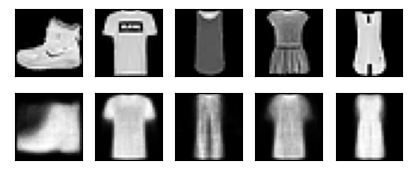

[Epoch 2]


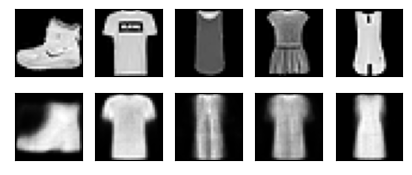

[Epoch 3]


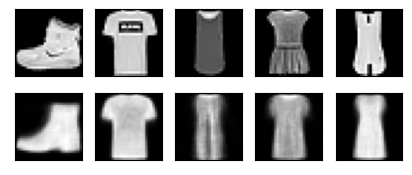

[Epoch 4]


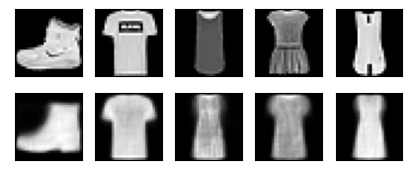

[Epoch 5]


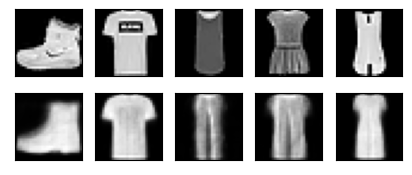

[Epoch 6]


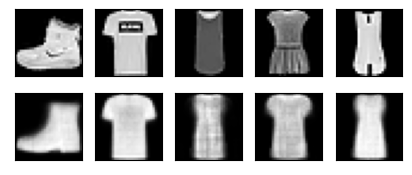

[Epoch 7]


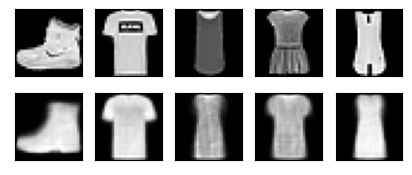

[Epoch 8]


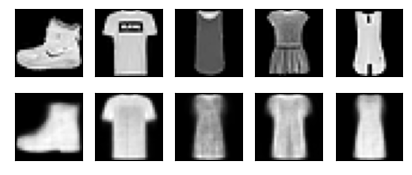

[Epoch 9]


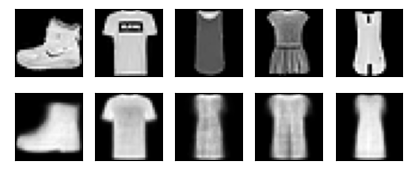

[Epoch 10]


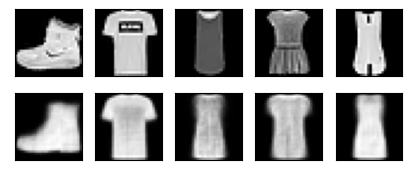

In [11]:
for epoch in range(1, EPOCH+1):
    train(autoencoder, train_loader)
    
    test_x = view_data.to(DEVICE)
    _,decoded_data = autoencoder(test_x)
    
    #시각화를 위한 코드
    f, a = plt.subplots(2,5,figsize=(5,2)) #행렬 플롯을 만들고
    print("[Epoch {}]".format(epoch))
    
    #원본 사진이 위에
    for i in range(5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
    #디코드된 이미지는 밑에
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i],(28,28))
        a[1][i].imshow(img,cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    #출력!!
    plt.show()